# Compare subsets

In [1]:
import os
import pandas as pd
import sys
import numpy as np
from pandas.core.common import flatten
import pickle
from pathlib import Path
import datetime
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import librosa.display
import random
from scipy.spatial.distance import pdist, squareform
import umap

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.legend import Legend
import matplotlib
import seaborn as sns
import string

from plot_functions import umap_2Dplot, mara_3Dplot, plotly_viz
from preprocessing_functions import pad_spectro, calc_zscore, create_padded_data
from evaluation_functions import nn,sil, plot_within_without

In [2]:
# Setting project, input and output folders.
wd = os.getcwd()
DATA = os.path.join(os.path.sep, str(Path(wd).parents[0]), "data", "processed")
FIGURES = os.path.join(os.path.sep, str(Path(wd).parents[0]), "reports", "figures")

LOAD_EXISTING = True
PLOTTING = False

In [3]:
nn_stats_dict = {}
embedding_dict= {}
embedding_2D_dict = {}
labels_dict = {}

for embedding_id in ['full', 'reduced','balanced', 'reducedrandom']:
    
    if embedding_id=="reducedrandom":
        spec_df = pd.read_pickle(os.path.join(os.path.sep, DATA, "df_focal_reduced.pkl"))
    else:
        spec_df = pd.read_pickle(os.path.join(os.path.sep, DATA, "df_focal_"+embedding_id+".pkl"))
    
    labels = spec_df.call_lable.values
    labels_dict[embedding_id] = labels
    
    # Prepare data
    specs = spec_df.spectrograms.copy()
    specs = [calc_zscore(x) for x in specs] 
    data = create_padded_data(specs)
    
    # UMAP
    #embedding_filename = os.path.join(os.path.sep, DATA,'basic_UMAP_'+embedding_id+'_default_params.csv')
    
    embeddings = {}
    
    for n_dims in [2,3]:
        dim_type = str(int(n_dims))+'D'
        embedding_filename = os.path.join(os.path.sep, DATA, 'basic_UMAP_'+dim_type+'_'+embedding_id+'_default_params.csv')
        print(embedding_filename)
        
        if (LOAD_EXISTING and os.path.isfile(embedding_filename)):
            embeddings[dim_type] = np.loadtxt(embedding_filename, delimiter=";")
            print("File already exists")
        else:
            if embedding_id=='reducedrandom':
                distmat = squareform(pdist(data, metric='euclidean'))

                flattened_dists = distmat[np.triu_indices(n=distmat.shape[0], k=1)]
                random.seed(100)
                np.random.shuffle(flattened_dists)
                random_distmat = np.zeros(distmat.shape)
                random_distmat[np.triu_indices(n=distmat.shape[0], k=1)] = flattened_dists
                for i in range(random_distmat.shape[0]):
                    for j in range(i,random_distmat.shape[1]):
                        random_distmat[j,i] = random_distmat[i,j]  

                reducer = umap.UMAP(n_components=n_dims, min_dist=0, metric='precomputed', random_state=2204)
                embeddings[dim_type] = reducer.fit_transform(random_distmat)

            else:
                reducer = umap.UMAP(n_components=3, min_dist = 0, random_state=2204)
                embeddings[dim_type] = reducer.fit_transform(data)

            np.savetxt(embedding_filename, embeddings[dim_type], delimiter=";")
    
    
    embedding = embeddings['3D']
    embedding_2D = embeddings['2D']
    
    embedding_dict[embedding_id] = embedding
    embedding_2D_dict[embedding_id] = embedding_2D
    
    # Plotting
    pal="Set2"

    ## 2D Plots
    if PLOTTING:
        umap_2Dplot(embedding_2D[:,0], 
                    embedding_2D[:,1], 
                    labels, 
                    pal, 
                    os.path.join(os.path.sep, FIGURES, 'UMAP_2D_plot_'+embedding_id+'_nolegend.jpg'), 
                    showlegend=False)
        plt.close()


        ## 3D Plot
        mara_3Dplot(embedding[:,0],
                    embedding[:,1],
                    embedding[:,2],
                    labels,
                    pal,
                    os.path.join(os.path.sep, FIGURES, 'UMAP_3D_plot_'+embedding_id+'_nolegend.jpg'),
                    showlegend=False)
        plt.close()


    # Embedding evaluation

    # Evaluate the embedding based on calltype labels of nearest neighbors.
    nn_stats = nn(embedding, np.asarray(labels), k=5)
    print("Log final metric (unweighted):",nn_stats.get_S())
    print("Abs final metric (unweighted):",nn_stats.get_Snorm())
    nn_stats_dict[embedding_id] = nn_stats
    

    if PLOTTING:
        nn_stats.plot_heat_S(outname=os.path.join(os.path.sep, FIGURES, 'heatS_UMAP_'+embedding_id+'.png'))
        nn_stats.plot_heat_Snorm(outname=os.path.join(os.path.sep, FIGURES, 'heatSnorm_UMAP_'+embedding_id+'.png'))
        nn_stats.plot_heat_fold(outname=os.path.join(os.path.sep, FIGURES, 'heatfold_UMAP_'+embedding_id+'.png'))


        ## Within vs. outside distances
        plot_within_without(embedding=embedding, labels=labels, outname="distanceswithinwithout_"+embedding_id+"_.png")
        plt.close()


    ## Silhouette Plot
    sil_stats = sil(embedding, labels)    
    print("SIL: ", sil_stats.get_avrg_score())
    
    if PLOTTING:
        sil_stats.plot_sil(outname=os.path.join(os.path.sep, FIGURES, 'silplot_UMAP_'+embedding_id+'.png'))
        plt.close()

        ## Graph from embedding evaluation
        outname = os.path.join(os.path.sep,FIGURES,'simgraph_'+embedding_id+'.png')
        nn_stats.draw_simgraph(outname)
        plt.close()

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/data/processed/basic_UMAP_2D_full_default_params.csv
File already exists
/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/data/processed/basic_UMAP_3D_full_default_params.csv
File already exists
Log final metric (unweighted): 58.738504037916584
Abs final metric (unweighted): 3.3612830847004114
SIL:  0.13651843916191067
/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/data/processed/basic_UMAP_2D_reduced_default_params.csv
File already exists
/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/data/processed/basic_UMAP_3D_reduced_default_params.csv
File already exists
Log final metric (unweighted): 61.34501086440152
Abs final metric (unweighted): 2.325701943362355
SIL:  0.20222915059559693
/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/data/processed/basic_UMAP_2D_balanced_default_params.csv
File already exists
/home/mthomas/Documents/MPI_work/projects/mee

# Paper figures

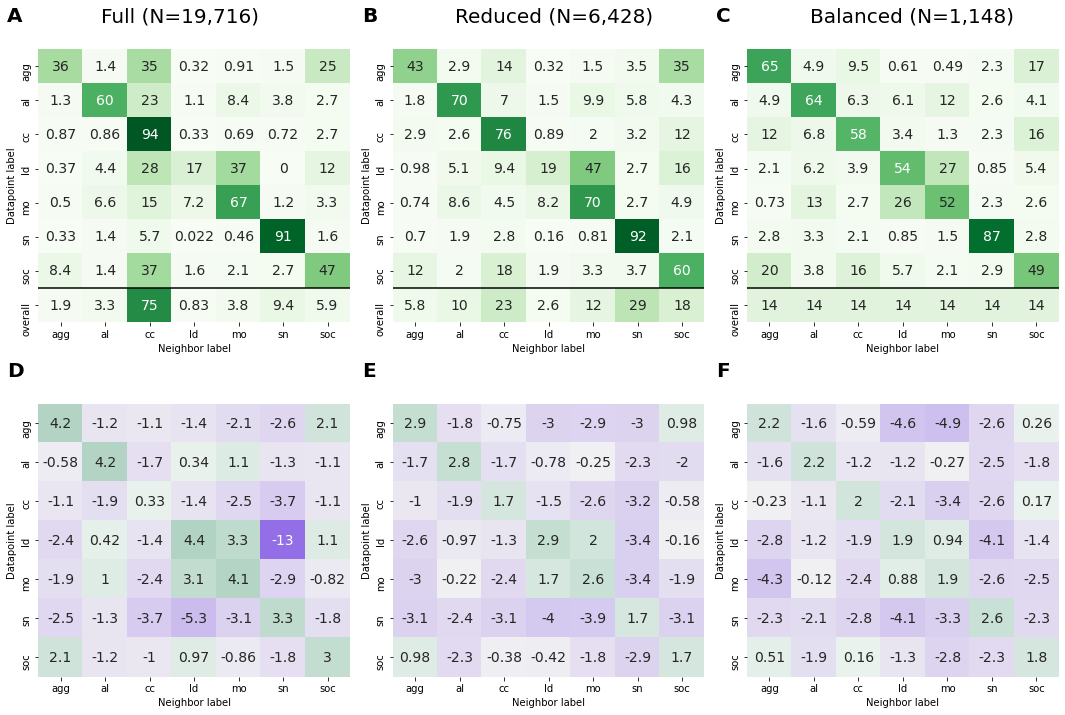

In [7]:
import string

fig, axes = plt.subplots(2,3, figsize=(15,10))

norm_palette = sns.diverging_palette(h_neg=275,s=80,l=55, h_pos=150, as_cmap=True)
abs_palette = sns.color_palette("Greens", as_cmap=True)

p1 = sns.heatmap(nn_stats_dict['full'].get_statstab(), annot=True, vmin=0, vmax=100, center=50, cmap=abs_palette, cbar=None, ax=axes[0][0], annot_kws={"size":14})
p1.set_xlabel("Neighbor label")
p1.set_ylabel("Datapoint label")
p1.axhline(y=len(set(labels)), color="black")
p1.text(-0.1, 1.1, string.ascii_uppercase[0], transform=axes[0][0].transAxes, 
      size=20, weight='bold')
p1.text(0.2, 1.1, "Full (N=19,716)", transform=axes[0][0].transAxes, 
      size=20)

p2 = sns.heatmap(nn_stats_dict['reduced'].get_statstab(), annot=True, vmin=0, vmax=100, center=50, cmap=abs_palette, cbar=None, ax=axes[0][1], annot_kws={"size":14})
p2.set_xlabel("Neighbor label")
p2.set_ylabel("Datapoint label")
p2.axhline(y=len(set(labels)), color="black")
p2.text(-0.1, 1.1, string.ascii_uppercase[1], transform=axes[0][1].transAxes, 
      size=20, weight='bold')     
p2.text(0.2, 1.1, "Reduced (N=6,428)", transform=axes[0][1].transAxes, 
      size=20)

p3 = sns.heatmap(nn_stats_dict['balanced'].get_statstab(), annot=True, vmin=0, vmax=100, center=50, cmap=abs_palette, cbar=None, ax=axes[0][2], annot_kws={"size":14})
p3.set_xlabel("Neighbor label")
p3.set_ylabel("Datapoint label")
p3.axhline(y=len(set(labels)), color="black")
p3.text(-0.1, 1.1, string.ascii_uppercase[2], transform=axes[0][2].transAxes, 
      size=20, weight='bold')     
p3.text(0.2, 1.1, "Balanced (N=1,148)", transform=axes[0][2].transAxes, 
      size=20)
        
p4 = sns.heatmap(nn_stats_dict['full'].get_statstabnorm(), annot=True, vmin=-13, vmax=13, center=0, cmap=norm_palette, cbar=None, ax=axes[1][0], annot_kws={"size":14})
p4.set_xlabel("Neighbor label")
p4.set_ylabel("Datapoint label")
p4.text(-0.1, 1.1, string.ascii_uppercase[3], transform=axes[1][0].transAxes, 
      size=20, weight='bold')

p5 = sns.heatmap(nn_stats_dict['reduced'].get_statstabnorm(), annot=True, vmin=-13, vmax=13, center=0, cmap=norm_palette, cbar=None, ax=axes[1][1], annot_kws={"size":14})
p5.set_xlabel("Neighbor label")
p5.set_ylabel("Datapoint label")
p5.text(-0.1, 1.1, string.ascii_uppercase[4], transform=axes[1][1].transAxes, 
      size=20, weight='bold')
                               
p6 = sns.heatmap(nn_stats_dict['balanced'].get_statstabnorm(), annot=True, vmin=-13, vmax=13, center=0, cmap=norm_palette, cbar=None, ax=axes[1][2], annot_kws={"size":14})
p6.set_xlabel("Neighbor label")
p6.set_ylabel("Datapoint label")
p6.text(-0.1, 1.1, string.ascii_uppercase[5], transform=axes[1][2].transAxes, 
      size=20, weight='bold')

plt.tight_layout()
plt.savefig(os.path.join(os.path.sep, FIGURES, 'paper_subsets_evals_other.png'), facecolor="white")

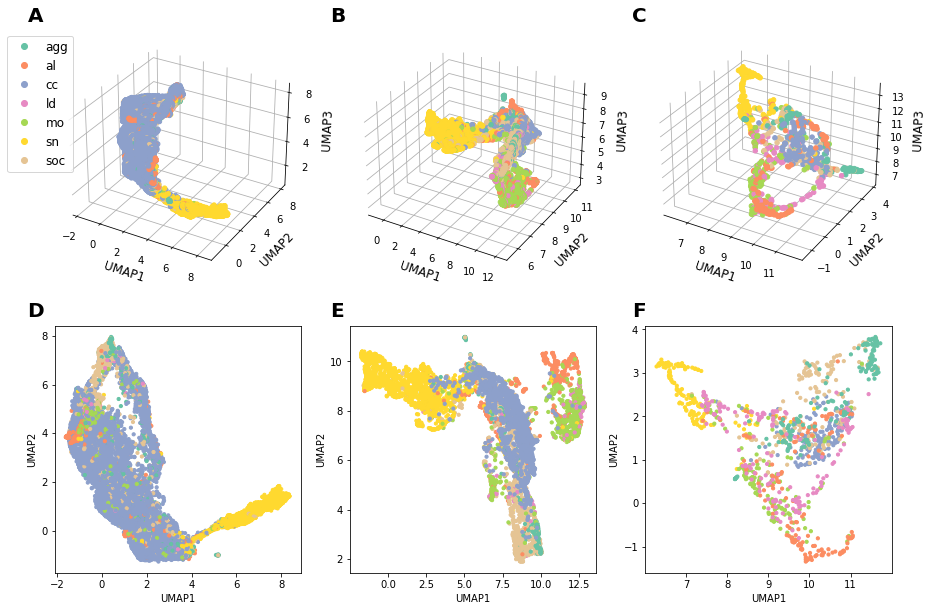

In [30]:
nrows = 2
ncols = 3


plt.figure(figsize=(15,10), facecolor="white")

# *************************************************

# FULL

# *************************************************

embedding_id = 'full'
embedding = embedding_dict[embedding_id]
embedding_2D = embedding_2D_dict[embedding_id]
labels = labels_dict[embedding_id]

ax = plt.subplot(nrows,ncols,1, projection='3d')
scat_labels = labels
mycolors = "Set2"

labeltypes = sorted(list(set(scat_labels)))
pal = sns.color_palette(mycolors, n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))
c = [color_dict[val] for val in scat_labels]
Axes3D.scatter(ax,
               xs = embedding[:,0],
               ys = embedding[:,1],
               zs = embedding[:,2],
               zdir='z',
               s=20,
               label = c,
               c=c,
               depthshade=False)

ax.set_xlabel('UMAP1', fontsize=12)
ax.set_ylabel('UMAP2', fontsize=12)
ax.set_zlabel('UMAP3', fontsize=12)
    
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
    
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

scatters = []
for label in labeltypes:
    scatters.append(matplotlib.lines.Line2D([0],[0], linestyle="none", c=color_dict[label], marker = 'o'))
ax.legend(scatters, labeltypes, numpoints = 1, fontsize=12, loc='upper right', bbox_to_anchor=(0.1,1))


plt.subplot(nrows,ncols,4)
labeltypes = sorted(list(set(scat_labels)))
pal = sns.color_palette(mycolors, n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))
c = [color_dict[val] for val in scat_labels]
    
plt.scatter(embedding_2D[:,0], embedding_2D[:,1], alpha=1,s=10, c=c)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2');

scatters = []
for label in labeltypes:
    scatters.append(matplotlib.lines.Line2D([0],[0], linestyle="none", c=color_dict[label], marker = 'o'))
#plt.legend(scatters, labeltypes, numpoints = 1) 

# *************************************************

# REDUCED

# *************************************************

embedding_id = 'reduced'
embedding = embedding_dict[embedding_id]
embedding_2D = embedding_2D_dict[embedding_id]
labels = labels_dict[embedding_id]

ax = plt.subplot(nrows,ncols,2, projection='3d')
scat_labels = labels
mycolors = "Set2"

labeltypes = sorted(list(set(scat_labels)))
pal = sns.color_palette(mycolors, n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))
c = [color_dict[val] for val in scat_labels]
Axes3D.scatter(ax,
               xs = embedding[:,0],
               ys = embedding[:,1],
               zs = embedding[:,2],
               zdir='z',
               s=20,
               label = c,
               c=c,
               depthshade=False)

ax.set_xlabel('UMAP1', fontsize=12)
ax.set_ylabel('UMAP2', fontsize=12)
ax.set_zlabel('UMAP3', fontsize=12)
    
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
    
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

scatters = []
for label in labeltypes:
    scatters.append(matplotlib.lines.Line2D([0],[0], linestyle="none", c=color_dict[label], marker = 'o'))
#ax.legend(scatters, labeltypes, numpoints = 1, fontsize=12, loc='upper right', bbox_to_anchor=(0.1,1))


plt.subplot(nrows,ncols,5)
labeltypes = sorted(list(set(scat_labels)))
pal = sns.color_palette(mycolors, n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))
c = [color_dict[val] for val in scat_labels]
    
plt.scatter(embedding_2D[:,0], embedding_2D[:,1], alpha=1,s=10, c=c)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2');

scatters = []
for label in labeltypes:
    scatters.append(matplotlib.lines.Line2D([0],[0], linestyle="none", c=color_dict[label], marker = 'o'))
#plt.legend(scatters, labeltypes, numpoints = 1) 


# *************************************************

# BALANCED

# *************************************************

embedding_id = 'balanced'
embedding = embedding_dict[embedding_id]
embedding_2D = embedding_2D_dict[embedding_id]
labels = labels_dict[embedding_id]

ax = plt.subplot(nrows,ncols,3, projection='3d')
scat_labels = labels
mycolors = "Set2"

labeltypes = sorted(list(set(scat_labels)))
pal = sns.color_palette(mycolors, n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))
c = [color_dict[val] for val in scat_labels]
Axes3D.scatter(ax,
               xs = embedding[:,0],
               ys = embedding[:,1],
               zs = embedding[:,2],
               zdir='z',
               s=20,
               label = c,
               c=c,
               depthshade=False)

ax.set_xlabel('UMAP1', fontsize=12)
ax.set_ylabel('UMAP2', fontsize=12)
ax.set_zlabel('UMAP3', fontsize=12)
    
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
    
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

scatters = []
for label in labeltypes:
    scatters.append(matplotlib.lines.Line2D([0],[0], linestyle="none", c=color_dict[label], marker = 'o'))
#ax.legend(scatters, labeltypes, numpoints = 1, fontsize=12, loc='upper right', bbox_to_anchor=(0.1,1))


plt.subplot(nrows,ncols,6)
labeltypes = sorted(list(set(scat_labels)))
pal = sns.color_palette(mycolors, n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))
c = [color_dict[val] for val in scat_labels]
    
plt.scatter(embedding_2D[:,0], embedding_2D[:,1], alpha=1,s=10, c=c)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2');

scatters = []
for label in labeltypes:
    scatters.append(matplotlib.lines.Line2D([0],[0], linestyle="none", c=color_dict[label], marker = 'o'))
#plt.legend(scatters, labeltypes, numpoints = 1) 



plt.figtext(0.1,0.89, "A", size=20, weight='bold')
plt.figtext(0.38,0.89, "B", size=20, weight='bold')
plt.figtext(0.66,0.89, "C", size=20, weight='bold')
plt.figtext(0.1,0.48, "D", size=20, weight='bold')
plt.figtext(0.38,0.48, "E", size=20, weight='bold')
plt.figtext(0.66,0.48, "F", size=20, weight='bold')

plt.savefig(os.path.join(os.path.sep, FIGURES, 'paper_subset_plots.png'), facecolor="white", bbox_inches="tight")

## SIL Plots

In [6]:
from sklearn.metrics import silhouette_samples, silhouette_score
import string

0.13651843916191067
0.20222915059559693
0.05137429832571731


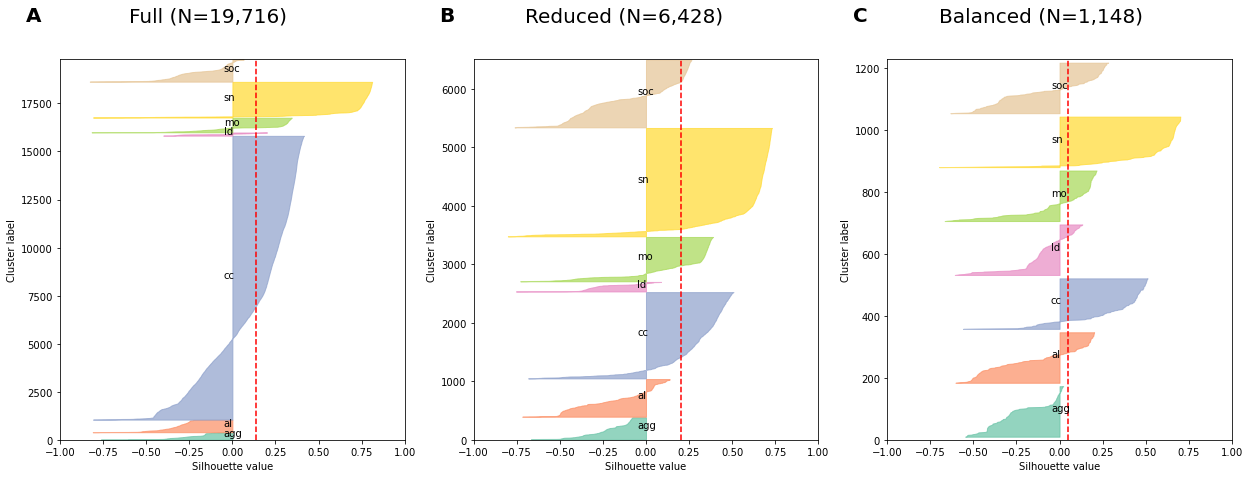

In [23]:
labels = labels_dict['full']
labeltypes = sorted(list(set(labels)))
n_clusters = len(labeltypes)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(21, 7)

# ***********************************

# FULL

# ************************************

embedding_id='full'
embedding = embedding_dict[embedding_id]
labels = labels_dict[embedding_id]


ax1.set_xlim([-1, 1])
ax1.set_ylim([0, embedding.shape[0] + (n_clusters + 1) * 10])
cluster_labels = labels
silhouette_avg = silhouette_score(embedding, cluster_labels)
print(silhouette_avg)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(embedding, cluster_labels)
y_lower = 10

pal = sns.color_palette("Set2", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))


for i, cluster_label in enumerate(labeltypes):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == cluster_label]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i


    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                    0, ith_cluster_silhouette_values,
                    facecolor=color_dict[cluster_label], edgecolor=color_dict[cluster_label], alpha=0.7)
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, cluster_label)

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_xlabel("Silhouette value")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.text(-0.1, 1.1, string.ascii_uppercase[0], transform=ax1.transAxes, 
      size=20, weight='bold')

ax1.text(0.2, 1.1, "Full (N=19,716)", transform=ax1.transAxes, 
      size=20)


# ***********************************

# REDUCED

# ************************************

embedding_id='reduced'
embedding = embedding_dict[embedding_id]
labels = labels_dict[embedding_id]

ax2.set_xlim([-1, 1])

ax2.set_ylim([0, embedding.shape[0] + (n_clusters + 1) * 10])
cluster_labels = labels
silhouette_avg = silhouette_score(embedding, cluster_labels)
print(silhouette_avg)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(embedding, cluster_labels)
y_lower = 10

pal = sns.color_palette("Set2", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))


for i, cluster_label in enumerate(labeltypes):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == cluster_label]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i


    ax2.fill_betweenx(np.arange(y_lower, y_upper),
                    0, ith_cluster_silhouette_values,
                    facecolor=color_dict[cluster_label], edgecolor=color_dict[cluster_label], alpha=0.7)
    ax2.text(-0.05, y_lower + 0.5 * size_cluster_i, cluster_label)

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

#ax2.set_title("Original")
ax2.set_xlabel("Silhouette value")
ax2.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax2.axvline(x=silhouette_avg, color="red", linestyle="--")
ax2.text(-0.1, 1.1, string.ascii_uppercase[1], transform=ax2.transAxes, 
      size=20, weight='bold')
ax2.text(0.15, 1.1, "Reduced (N=6,428)", transform=ax2.transAxes, 
      size=20)

# ***********************************

# BALANCED

# ************************************

embedding_id='balanced'
embedding = embedding_dict[embedding_id]
labels = labels_dict[embedding_id]

ax3.set_xlim([-1, 1])

ax3.set_ylim([0, embedding.shape[0] + (n_clusters + 1) * 10])
cluster_labels = labels
silhouette_avg = silhouette_score(embedding, cluster_labels)
print(silhouette_avg)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(embedding, cluster_labels)
y_lower = 10

pal = sns.color_palette("Set2", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))


for i, cluster_label in enumerate(labeltypes):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == cluster_label]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i


    ax3.fill_betweenx(np.arange(y_lower, y_upper),
                    0, ith_cluster_silhouette_values,
                    facecolor=color_dict[cluster_label], edgecolor=color_dict[cluster_label], alpha=0.7)
    ax3.text(-0.05, y_lower + 0.5 * size_cluster_i, cluster_label)

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

#ax2.set_title("Original")
ax3.set_xlabel("Silhouette value")
ax3.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax3.axvline(x=silhouette_avg, color="red", linestyle="--")
ax3.text(-0.1, 1.1, string.ascii_uppercase[2], transform=ax3.transAxes, 
      size=20, weight='bold')
ax3.text(0.15, 1.1, "Balanced (N=1,148)", transform=ax3.transAxes, 
      size=20)
#plt.show()
plt.savefig(os.path.join(os.path.sep,FIGURES,'paper_subsets_SILs.png'), facecolor="white")

In [24]:
labeltypes = sorted(list(set(labels)))
n_clusters = len(labeltypes)


for embedding_id in ['full', 'reduced', 'balanced']:
    
    embedding = embedding_dict[embedding_id]
    cluster_labels = labels_dict[embedding_id]

    # Compute the silhouette scores for each sample
    print("****************************")
    print(embedding_id)
    print("****************************")
    
    
    sample_silhouette_values = silhouette_samples(embedding, cluster_labels)
    sil_per_type = []
    for i, cluster_label in enumerate(labeltypes):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == cluster_label]
        print(cluster_label, ' : ', np.mean(ith_cluster_silhouette_values))
        sil_per_type.append(np.mean(ith_cluster_silhouette_values))
    print("Total mean: ", np.mean(np.asarray(sil_per_type)))

****************************
full
****************************
agg  :  -0.2596330359917905
al  :  -0.3470295770420023
cc  :  0.12462495106142145
ld  :  -0.09939733363437439
mo  :  0.1434490870044009
sn  :  0.69824514336166
soc  :  -0.18630000045213585
Total mean:  0.010565604901025602
****************************
reduced
****************************
agg  :  -0.2264691287221279
al  :  -0.17654142754280694
cc  :  0.2755989042994892
ld  :  -0.23426466781574298
mo  :  0.18857774628283575
sn  :  0.573221230848488
soc  :  -0.06568346922524006
Total mean:  0.04777702687498501
****************************
balanced
****************************
agg  :  -0.22002814464825926
al  :  -0.1308398300907034
cc  :  0.30292704709123
ld  :  -0.09679584211496
mo  :  0.01970221484428234
sn  :  0.5459978274951283
soc  :  -0.06134318429669663
Total mean:  0.05137429832571732
